# Narcos

The very mention of South America often evokes violent images from the Narcos Netflix series of Pablo Escobar's bloody rise to power and drug empire in Colombia. This project takes a look at the data, including violent crime, terror risk, gender violence and natural disaster risk, to see if South America is still an exceptionally dangerous place to be in comparison to other countries.

## Import libraries

In [1]:
import pandas as pd

path = 'C:\\Users\\Jack-\\OneDrive\\Desktop\\Projects\\Narcos\\'

## Import data

### Violent Crime

In [2]:
# reads in the data. This spreadsheet (political stability/lack of terrorism - World Bank) 
# would not read in properly so an average was taken from 2015-2022 manually using excel. 
VC_data = pd.read_csv(path + 'violent crime.csv')

# renames columns
VC_data.columns = ['country', 'violent_crime']

# makes more desirable values higher
#VC_data.loc[:,'violent_crime'] = 100 - VC_data.loc[:,'violent_crime']

# shows the data
VC_data.head(6)

,country,violent_crime
0,Aruba,NaN
1,Africa Eastern and Southern,10.300000
2,Afghanistan,6.858469
3,Africa Western and Central,8.100000
4,Angola,4.280242
5,Albania,2.281747


### Terror Risk

In [3]:
# reads in the data. This spreadsheet (political stability/lack of terrorism - World Bank) 
# would not read in properly so an average was taken from 2015-2022 manually using excel. 
TR_data = pd.read_csv(path + 'terror risk.csv')

# renames columns
TR_data.columns = ['country', 'terror_risk']

# makes less desirable values higher
TR_data.loc[:,'terror_risk'] = 100 - TR_data.loc[:,'terror_risk']

# shows the data
TR_data.head(6)

,country,terror_risk
0,Aruba,4.621517
1,Africa Eastern and Southern,NaN
2,Afghanistan,99.230683
3,Africa Western and Central,NaN
4,Angola,71.648698
5,Albania,45.194294


### Gender Violence

In [4]:
# reads in the data
raw_GV_data = pd.read_csv(path + 'sexual violence in the last 12 months (%).csv')

# filters for the most recent year
raw_GV_data = raw_GV_data[raw_GV_data['Year']==2018]

# filters for disaggregation type
raw_GV_data = raw_GV_data[raw_GV_data['Disaggregation']=='female, 15-49, Modeled']

# removes uneeded columns
GV_data = raw_GV_data.iloc[:,[2,5]]

# renames columns
GV_data.columns = ['country', 'gender_violence']

# makes more desirable values higher
#GV_data.loc[:,'gender_violence'] = 100 - GV_data.loc[:,'gender_violence']

# shows the data
GV_data.head(6)

,country,gender_violence
0,East Asia & Pacific,7.928985
1,Europe & Central Asia,6.317913
2,High income,5.601072
3,Latin America & Caribbean,8.306678
4,Low income,22.482199
5,Lower middle income,16.864853


## Create dataframe

In [5]:
# returns the country name of a dataframe given a string
def get_country_name(data, string, col_name='country'):
    result = data.loc[[string in x for x in data[col_name]], col_name].values
    if len(result)>1:
        print()
        print('2 countries with same name!!!!' + ' --- ' + result)
    else:
        return result[0]

# changes a country name to make it uniform
def change_country_name(data, name, country, col_name='country'):
    data.loc[data[col_name]==name, col_name] = country

# standardizes country names for a certain dataframe
def standardize_df_country_names(df, col_name='country'):
    for country in countries:
        name = get_country_name(df, country)
        if name != country:
            change_country_name(df, name, country)

# a list of relevant countries
countries = ['Colombia', 'Brazil', 'Peru', 'Argentina', 'Venezuela', 'Chile', 'Ecuador', 'Bolivia', 'Uruguay', 'Paraguay', 'Guyana', 'Suriname', 
             'Trinidad and Tobago', 'Panama', 'Guatemala', 'El Salvador', 'Belize', 'Nicaragua', 'Honduras', 'Costa Rica', 'Dominican Republic',
             'Cuba', 'Jamaica', 'Haiti', 'Mexico']


# sorts the countries by country name
countries.sort()

# a list of relevant dataframes
dfs = ['VC_data', 'TR_data', 'GV_data']

# creates a dataframe object
combined_df = pd.DataFrame({'country': countries})

# loops through each dataframe and stores relevant values in the dataframes object
for df in dfs:
    try:
        standardize_df_country_names(eval(df))
    except:
        print('WARNING!!! ' + df + ' does not have a country!')

# warns if a country name has been entered twice
if not len(combined_df) == len(combined_df['country'].unique()):
    print('CAREFUL! You appear to have duplicated a country name there!')

# assigns columns to a new dataframe
columns = ['Crime', 'Terror', 'Gender']
for i, df in enumerate(dfs):
    combined_df[columns[i]] = eval(df)[eval(df)['country'].isin(countries)].sort_values('country').reset_index(drop=True).iloc[:,1]

# prints the number of countries in the dataframe
print()
print('Countries: ' + str(len(combined_df)))
print()

# shows the dataframe
combined_df.head(6)


Countries: 25



,country,Crime,Terror,Gender
0,Argentina,5.477446,52.119834,5.0
1,Belize,33.925396,47.410714,8.0
2,Bolivia,4.754433,66.558849,18.0
3,Brazil,26.394857,69.757412,6.0
4,Chile,3.828549,44.832098,6.0
5,Colombia,26.045086,82.374214,12.0


## View NAs

In [6]:
# determuine how many NAs are in each data source
new_df = combined_df.iloc[:,1:len(combined_df.columns)]
cols = new_df.columns

print()
for i, col in enumerate(cols):
    print(str(col) + ' --- NAs --- ' + str(new_df.iloc[:,i].isnull().sum()))


Crime --- NAs --- 0
Terror --- NAs --- 0
Gender --- NAs --- 0


## Normalize values

In [7]:
# normalizes values by scalling to range, multiplying the result by 5 and then rounding that to the nearest 2 digits.
# this gives us a relative 0-5 score for each column. 
def normalize_values(df, column):
    max = df[column].max()
    min = df[column].min()
    return [round(((x - min) / (max - min)) * 5, 2) for x in df[column]]

# creates a combined df with normalized values
columns = combined_df.columns
for column in columns[1:]:
    combined_df[column] = normalize_values(combined_df, column)

# shows the dataframe
combined_df.head(6)

,country,Crime,Terror,Gender
0,Argentina,0.16,2.56,0.36
1,Belize,2.94,2.25,1.43
2,Bolivia,0.09,3.52,5.00
3,Brazil,2.20,3.73,0.71
4,Chile,0.00,2.07,0.71
5,Colombia,2.17,4.57,2.86


## Visualize the data

### South America

In [8]:
import matplotlib.pyplot as plt

# defines the countries we want to look at
SA_countries = ['Colombia', 'Brazil', 'Peru', 'Argentina', 'Venezuela', 'Chile', 'Ecuador', 'Bolivia']

# creates a new dataframe
SA_df = combined_df.loc[[True if x in SA_countries else False for x in combined_df['country']]].reset_index(drop=True)

# shows the dataframe
SA_df

,country,Crime,Terror,Gender
0,Argentina,0.16,2.56,0.36
1,Bolivia,0.09,3.52,5.00
2,Brazil,2.20,3.73,0.71
3,Chile,0.00,2.07,0.71
4,Colombia,2.17,4.57,2.86
5,Ecuador,0.36,3.07,1.43
6,Peru,0.34,3.40,2.50
7,Venezuela,3.62,5.00,1.43


### Visualization

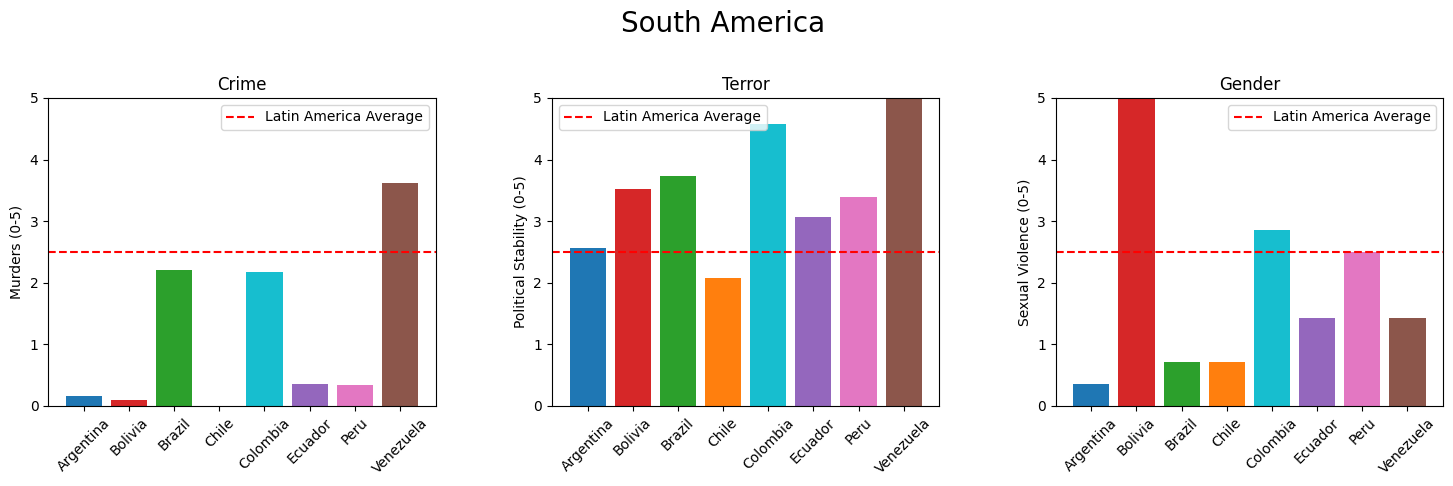

In [14]:
import numpy as np

# defines the colors we want to use
colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:orange', 'tab:cyan', 'tab:purple', 'tab:pink', 'tab:brown', 'black']

# creates a list of ylabels
ylabels = ['Murders (0-5)', 'Political Stability (0-5)', 'Sexual Violence (0-5)']

def get_viz(df, title):

    # creates an x object of country names
    x = df['country']

    # stores the column names as Ys
    Ys = df.columns[1:]
    
    # creates a subplots objects and flattenes it for easy plotting
    fig, ax = plt.subplots(1, 3, figsize=(18, 4))
    #ax = ax.flatten()
    
    # loops through each plot
    for i, y in enumerate(Ys):
        ax[i].bar(x, df[y], color=colors);
        ax[i].set_title(' '.join(y.split('_')).title());
        ax[i].set_ylabel(ylabels[i]);
        ax[i].set_ylim(0,5);
        ax[i].set_xticks(x);
        ax[i].set_xticklabels(x, rotation=45);
        ax[i].axhline(y=2.5, color='red', linestyle='--', label='Latin America Average')
        ax[i].legend()
    
    # adjust layout for better spacing
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    
    # add overall title
    fig.suptitle(title, fontsize=20, y=1.1)
    
    # show the plots
    plt.show()

# get visualization
get_viz(SA_df, 'South America')

### Central & North America

In [10]:
# defines the countries we want to look at
CA_countries = ['Panama', 'Guatemala', 'El Salvador', 'Belize', 'Nicaragua', 'Honduras', 'Costa Rica', 'Mexico']

# creates a new dataframe
CA_df = combined_df.loc[[True if x in CA_countries else False for x in combined_df['country']]].reset_index(drop=True)

# shows the dataframe
CA_df

,country,Crime,Terror,Gender
0,Belize,2.94,2.25,1.43
1,Costa Rica,0.75,1.13,1.07
2,El Salvador,5.00,3.00,0.71
3,Guatemala,2.09,3.88,1.07
4,Honduras,3.86,3.93,1.07
5,Mexico,2.13,4.35,2.14
6,Nicaragua,0.46,3.68,0.71
7,Panama,0.69,1.94,1.43


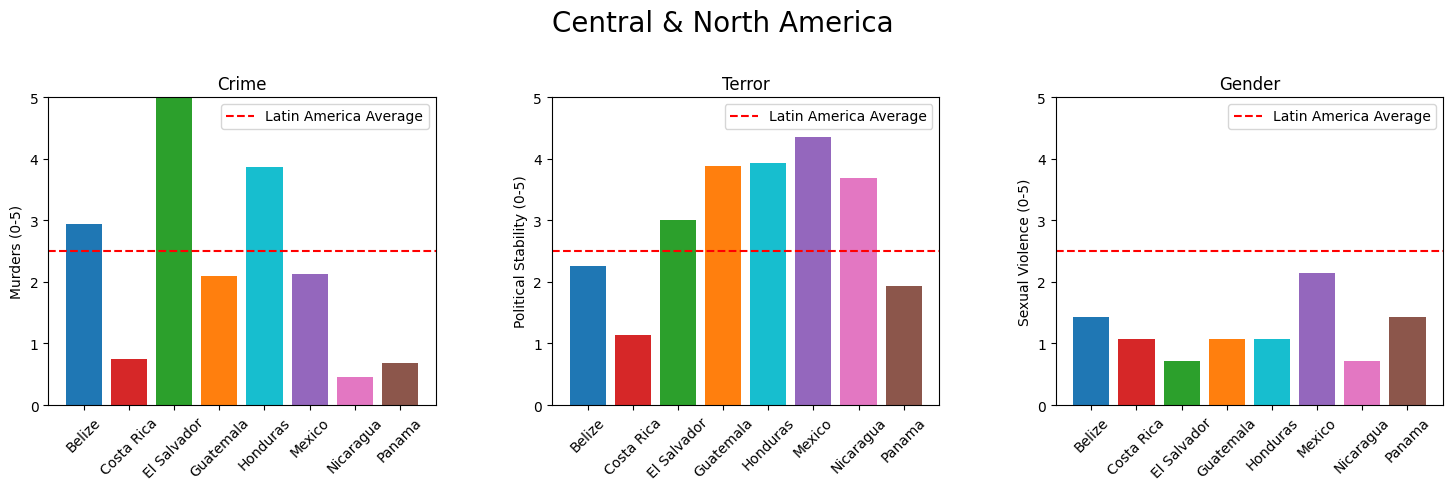

In [17]:
# get visualization
get_viz(CA_df, 'Central & North America')

### The Caribbean

In [12]:
# defines the countries we want to look at
C_countries = ['Dominican Republic', 'Cuba', 'Jamaica', 'Haiti', 'Trinidad and Tobago']

# creates a new dataframe
C_df = combined_df.loc[[True if x in C_countries else False for x in combined_df['country']]].reset_index(drop=True)

# shows the dataframe
C_df

,country,Crime,Terror,Gender
0,Cuba,0.09,1.41,0.36
1,Dominican Republic,0.69,2.25,2.14
2,Haiti,0.62,4.55,2.86
3,Jamaica,4.41,1.97,1.07
4,Trinidad and Tobago,2.68,2.12,1.07


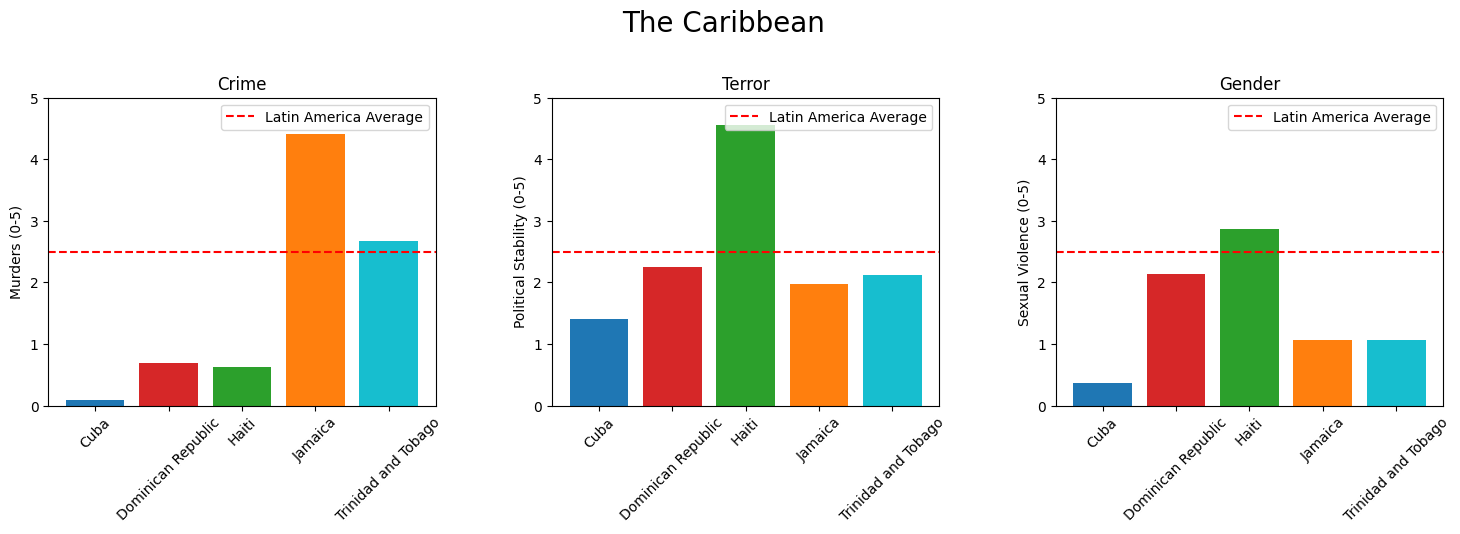

In [16]:
# get visualization
get_viz(C_df, 'The Caribbean')